In [1]:
import pandas as pd
from py2neo import Graph
import networkx as nx
import zss
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import math
import json

import geopy.distance
from geopy.distance import geodesic

In [6]:
#paths
path = 'C:/Users/hugop/Desktop/Thèse finaux/sts_france_paris_merged_deletion'

In [7]:
communities = ['FRA', 'UK', 'USA', 'SPA', 'ITA']
years = [2013,2014,2015,2016,2017,2018]

In [9]:
df_list = []
names_list = []
for i in communities:
    for x in years:
        df = pd.read_csv(f'{path}/MAXST{i}{x}.csv')
        df = df[['source', 'destination', 'cost']]
        df_list.append(df)
        names_list.append(f'{i}{x}')

In [10]:
graph_list = []
df_list_aslist = []
for x in range(len(df_list)):
    g = nx.DiGraph()
    for i, elrow in df_list[x].iterrows():
        g.add_edge(elrow[0], elrow[1])
    df_list[x]['cost'] = 1/df_list[x]['cost']
    df_list_aslist.append(df_list[x].values.tolist())
    g.add_weighted_edges_from(df_list_aslist[x], weight='cost')
    graph_list.append(g)

In [11]:
def make_edge_df(G):
    edges = {}
    for source, target, attribute in G.edges(data=True):

        if not edges.get('source'):
            edges['source'] = [source]
        else:
            edges['source'].append(source)

        if not edges.get('target'):
            edges['target'] = [target]
        else:
            edges['target'].append(target)

        for key, value in attribute.items():
            if not edges.get(key):
                edges[key] = [value]
            else:
                edges[key].append(value)
    return pd.DataFrame(edges)

In [12]:
df_list_sts = []
for i in range(len(graph_list)):
    df = make_edge_df(graph_list[i])
    df = df.rename(columns={"target": "destination"})
    #df = df[['source', 'destination']]
    df['cost'] = 1/df['cost']
    df_list_sts.append(df)

In [19]:
from urllib.request import urlopen, Request
import json

def ajout_coordonnees_liste_df(df_list):
    for i in range(len(df_list)):
        df_list[i] = df_list[i].merge(df_source, how = 'inner', on = ['source'])
        df_list[i] = df_list[i].merge(df_dest, how = 'inner', on = ['destination'])
    return df_list

def distance(df):
    r,c = df.shape
    df['distance'] = 0.
    for i in range(r):
        if df['sourcelat'][i] != 0 and df['sourcelong'][i] != 0 and df['destlat'][i]!=0 and df['destlong'][i]!=0 :
            coords_1 = (df['sourcelat'][i],df['sourcelong'][i])
            coords_2 = (df['destlat'][i],df['destlong'][i])
            
            df['distance'][i] = geodesic(coords_1, coords_2).km
        else:
            df['distance'][i] = -1
    return df

request=Request('https://data.dvrc.fr/api/getGeoJSON_all.php?zone_type=0&country=France&zone=FRA&agg=3')
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)
df = pd.json_normalize(data['features'])

df = df.drop(['type','geometry.type','geometry.coordinates','properties.gid_2','properties.gid_1','properties.name_1'], axis=1)
df = df.rename(columns={"properties.name_3": "name_3", "properties.centroidlong": "centroidlong","properties.centroidlat": "centroidlat"})
df_source = df.rename(columns={"name_3": "source", "centroidlong": "sourcelong", "centroidlat":"sourcelat"})
df_dest = df.rename(columns={"name_3": "destination", "centroidlong": "destlong", "centroidlat":"destlat"})

df_list_sts = ajout_coordonnees_liste_df(df_list_sts)

for i in range(len(df_list_sts)):
    df_list_sts[i] = distance(df_list_sts[i])

C:\Users\hugop\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
avg = []
for i in range(len(df_list_sts)):
    avg.append(df_list_sts[i]['distance'].sum()/(df_list_sts[i].shape[0]))

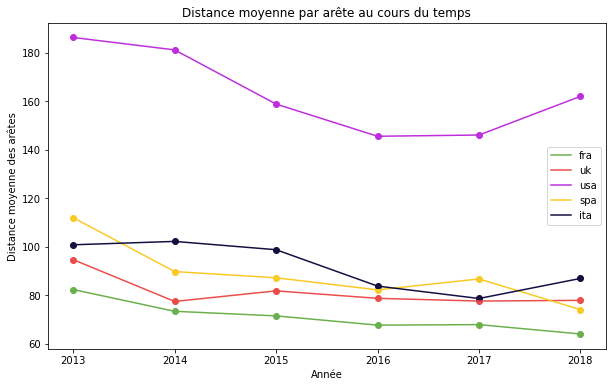

In [22]:
years= list(range(2013,2019))

plt.figure(figsize=(10,6))
plt.title('Distance moyenne par arête au cours du temps')
plt.ylabel('Distance moyenne des arêtes')
plt.xlabel('Année')
# Create a scatter plot of betweenness centrality and degree centrality
plt.plot( years,avg[0:6], color = '#6ab04c',  label=f'fra')
plt.scatter(years,avg[0:6], color = '#6ab04c')
plt.plot( years,avg[6:12], color = '#eb4d4b',  label=f'uk')
plt.scatter(years,avg[6:12], color = '#eb4d4b')
plt.plot( years,avg[12:18], color = '#be2edd',  label=f'usa')
plt.scatter(years,avg[12:18], color = '#be2edd')
plt.plot( years,avg[18:24], color = '#f9ca24',label=f'spa')
plt.scatter(years,avg[18:24], color = '#f9ca24')
plt.plot( years,avg[24:30], color = '#130f40',  label=f'ita')
plt.scatter(years,avg[24:30], color = '#130f40')
plt.legend()
# Display the plot
plt.show()

In [24]:
def noeud_central_dans_larbre(g):
    dict_moy = {}
    for n in g.nodes():
        tmp=0
        v = 0
        for x in g.nodes():
            if x != n:
                tmp+=nx.shortest_path_length(nx.to_undirected(g),n,x)
        v = tmp/((len(g.nodes()))-1)
        #dict_moy[n].append(v)
        dict_moy.update({n:v})
    return min(dict_moy.keys(), key=(lambda k: dict_moy[k]))

In [25]:
centers = []
for i in range(len(df_list_sts)):
    centers.append(noeud_central_dans_larbre(graph_list[i]))

In [26]:
def get_max_betweeness(g):
    inverse = [(value, key) for key, value in nx.betweenness_centrality(nx.to_undirected(g), weight='cost').items()]
    return max(inverse)[0]

def tree_hierarchy(g,df,root):
    M = df.shape[0]
    #print('M '+str(M))
    L = leaf_fraction(g)
    #print('L '+str(L))
    BC_max = get_max_betweeness(g)
    #print('BC_max '+str(BC_max))
    return L/(2*M*BC_max)

def tree_hierarchy_list(l,l2,l3):
    lst = [0]*len(l)
    for i in range(len(l)):
        lst[i] = tree_hierarchy(l[i],l2[i],l3[i])
    return lst

def leaf_fraction(g):
    c=0
    for i in g.nodes():
        if len(list(g.neighbors(i))) == 1:
            c +=1
    return c/(len(g.nodes()))

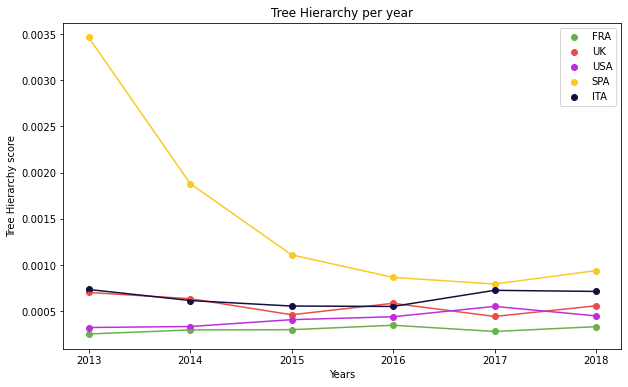

In [28]:
### Compute the betweenness centrality of T: bet_cen
hierarchy_fra = tree_hierarchy_list(graph_list[0:6],df_list_sts[0:6], centers[0:6])
hierarchy_uk = tree_hierarchy_list(graph_list[6:12],df_list_sts[6:12], centers[6:12])
hierarchy_usa = tree_hierarchy_list(graph_list[12:18],df_list_sts[12:18], centers[12:18])
hierarchy_spa = tree_hierarchy_list(graph_list[18:24],df_list_sts[18:24], centers[18:24])
hierarchy_ita = tree_hierarchy_list(graph_list[24:30],df_list_sts[24:30], centers[24:30])
# Compute the degree centrality of T: deg_cen
years= list(range(2013,2019))

plt.figure(figsize=(10,6))
plt.title('Tree Hierarchy per year')
plt.ylabel('Tree Hierarchy score')
plt.xlabel('Years')

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(years,hierarchy_fra,color='#6ab04c', label='FRA')
plt.plot(years,hierarchy_fra, color='#6ab04c')
plt.scatter(years,hierarchy_uk, color='#eb4d4b', label='UK')
plt.plot(years,hierarchy_uk, color='#eb4d4b')
plt.scatter(years,hierarchy_usa, color='#be2edd', label='USA')
plt.plot(years,hierarchy_usa, color='#be2edd')
plt.scatter(years,hierarchy_spa,color='#f9ca24', label='SPA')
plt.plot(years,hierarchy_spa, color='#f9ca24')
plt.scatter(years,hierarchy_ita,color='#130f40', label='ITA')
plt.plot(years,hierarchy_ita, color='#130f40')
plt.legend()
# Display the plot
plt.show()

In [29]:
import folium
def draw_graph(df1):
    m = folium.Map(location=[48.8534, 2.3488], zoom_start=6,max_zoom=15,min_zoom=2, tiles='cartodbpositron')
    
    url = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/metropole.geojson'
    
    m.choropleth(geo_data=url,
            fill_color='orange',
            line_opacity = 0.8,
            fill_opacity = 0.3
    
) 
    
    for i in range(0,len(df1)):
        p1=[float(df1.iloc[i]['sourcelat']), float(df1.iloc[i]['sourcelong'])]
        p2=[float(df1.iloc[i]['destlat']), float(df1.iloc[i]['destlong'])]
        
    
    
        folium.Circle(
            p1,
            tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df1.iloc[i]['source'],
            radius=5,
            color='#000000',
            fill_color='#000000',
            opacity = 0.8,
            fill=True).add_to(m)
    
        folium.Circle(
            p2,
            tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df1.iloc[i]['destination'],
            radius=5,
            color='#000000',
            fill_color='#000000',
            fill=True).add_to(m)
    for i in range(0,len(df1)):
        p1=[float(df1.iloc[i]['sourcelat']), float(df1.iloc[i]['sourcelong'])]
        p2=[df1.iloc[i]['destlat'], df1.iloc[i]['destlong']]
        _str = f"cout : {df1.iloc[i]['cost']}  \t distance : {df1.iloc[i]['distance']}"
        folium.PolyLine(locations=[p1, p2],popup = _str, color='#000000', opacity=0.8).add_to(m)

        
    return(m)



In [30]:
draw_graph(df_list_sts[7])

C:\Users\hugop\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## RIF LOG BASE

In [32]:
def distance_path(liste, df):
    distance=0.
    for i in range(0, len(liste)-1):
        for r in range(df.shape[0]):
            if df.at[r,'source'] == liste[i]:
                if df.at[r,'destination'] == liste[i+1]:
                    distance+=df.at[r,'distance']
    return distance

In [33]:
def distance_max_path_from_center(g, df, center):
    _max = 0
    dists = []
    for n in g.nodes():
        if n != center:
            if distance_path(nx.shortest_path(g, center, n),df) > _max:
                _max = distance_path(nx.shortest_path(g, center, n),df)
            dists.append(_max)
    return max(dists)

In [34]:
def distance_racine_noeud_geodesique(g, df, center,n):
    return distance_path(nx.shortest_path(nx.to_undirected(g), center, n),df)

In [35]:
def alternative_th(g, df, center):
    s=0
    _max = distance_max_path_from_center(nx.to_undirected(g), df, center)
    for x in g.nodes():
        if x != center and distance_racine_noeud_geodesique(g, df, center,x) != 0:
            s+=math.log(distance_racine_noeud_geodesique(g, df, center,x),_max)*(1/(nx.betweenness_centrality(g, weight='cost')[x]+1))
    return s/((len(g.nodes())-1)*(len(g.nodes())))

In [36]:
import operator

In [37]:
def contribution_rif(g, df, center):
    s=0
    dicts = {}
    _max = distance_max_path_from_center(nx.to_undirected(g), df, center)
    node = []
    contrib = []
    bc = []
    distance = []
    #df = pd.DataFrame(columns=['Node', 'Contribution RIF', 'BC(n)', 'Distance au centre'])
    for x in g.nodes():
        if x != center and distance_racine_noeud_geodesique(g, df, center,x) != 0:
            s=math.log(distance_racine_noeud_geodesique(g, df, center,x),_max)*(1/(nx.betweenness_centrality(g, weight='cost')[x]+1))
            node.append(x)
            contrib.append(s/((len(g.nodes())-1)*(len(g.nodes()))))
            bc.append(nx.betweenness_centrality(g, weight='cost')[x])
            distance.append(distance_racine_noeud_geodesique(g, df, center,x))
            #new_row = {'Node': x, 'Contribution RIF': s/((len(g.nodes())-1)*(len(g.nodes()))), 'BC(n)': nx.betweenness_centrality(g, weight='cost')[x], 'Distance au centre':distance_racine_noeud_geodesique(g, df, center,x)}
            #new_row = pd.Series(data={'Node': x, 'Contribution RIF': s/((len(g.nodes())-1)*(len(g.nodes()))), 'BC(n)': nx.betweenness_centrality(g, weight='cost')[x], 'Distance au centre':distance_racine_noeud_geodesique(g, df, center,x)}, name='x')
            #df = df.append(new_row)
            #print("Node name: " + x + "; RIF contribution: " + s/((len(g.nodes())-1)*(len(g.nodes()))) + "BC(n): " + nx.betweenness_centrality(g, weight='cost')[x]+ "Distance au centre" + distance_racine_noeud_geodesique(g, df, center,x))
    
    data = {'Node':node, 'Contribution RIF':contrib, 'BC(n)':bc, 'Distance au centre': distance} 
    df = pd.DataFrame(data)
    return df

In [38]:
pd.set_option("display.max_rows", 10000, "display.max_columns", None)
df = contribution_rif(graph_list[17], df_list_sts[17], centers[17]).sort_values(by=['Contribution RIF'], ascending=False)
#df.to_csv('C:/Users/hugop/Desktop/Contributions_RIF_France_2018.csv',  sep=',')

In [39]:
def alternative_th_list(l,l2,l3):
    lst = [0]*len(l)
    for i in range(len(l)):
        lst[i] = alternative_th(l[i],l2[i],l3[i])
    return lst

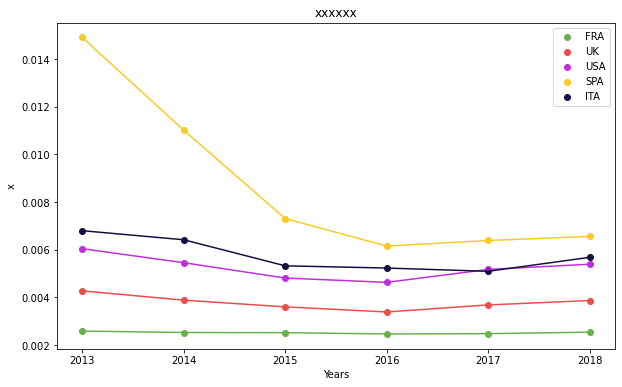

In [41]:
### Compute the betweenness centrality of T: bet_cen
hierarchy_fra = alternative_th_list(graph_list[0:6],df_list_sts[0:6], centers[0:6])
hierarchy_uk = alternative_th_list(graph_list[6:12],df_list_sts[6:12], centers[6:12])
hierarchy_usa = alternative_th_list(graph_list[12:18],df_list_sts[12:18], centers[12:18])
hierarchy_spa = alternative_th_list(graph_list[18:24],df_list_sts[18:24], centers[18:24])
hierarchy_ita = alternative_th_list(graph_list[24:30],df_list_sts[24:30], centers[24:30])
# Compute the degree centrality of T: deg_cen
years= list(range(2013,2019))

plt.figure(figsize=(10,6))
plt.title('xxxxxx')
plt.ylabel('x')
plt.xlabel('Years')

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(years,hierarchy_fra,color='#6ab04c', label='FRA')
plt.plot(years,hierarchy_fra, color='#6ab04c')
plt.scatter(years,hierarchy_uk, color='#eb4d4b', label='UK')
plt.plot(years,hierarchy_uk, color='#eb4d4b')
plt.scatter(years,hierarchy_usa, color='#be2edd', label='USA')
plt.plot(years,hierarchy_usa, color='#be2edd')
plt.scatter(years,hierarchy_spa,color='#f9ca24', label='SPA')
plt.plot(years,hierarchy_spa, color='#f9ca24')
plt.scatter(years,hierarchy_ita,color='#130f40', label='ITA')
plt.plot(years,hierarchy_ita, color='#130f40')
plt.legend()
# Display the plot
plt.show()

In [45]:
contrib_liste = []
for i in range(len(df_list_sts)):
    a = contribution_rif(graph_list[i], df_list_sts[i], centers[i])
    a['dfname'] = names_list[i]
    contrib_liste.append(a)

df_contrib = pd.concat(contrib_liste)

In [46]:
df_contrib = df_contrib.reset_index(drop=True)

In [50]:
df_contrib = a.rename(columns={'Node': 'name', 'Contribution RIF': 'Contribution_RIF', 'BC(n)': 'BCn', 'Distance au centre': 'Distance au centre', 'dfname':'dfname', 'centroidlong':'longitude', 'centroidlat':'latitude'})

In [54]:
df_contrib.to_json(r'C:\Users\hugop\Desktop\react_app_dvrc\project\src\data\contrib_locations_area3_france.json', orient='records', force_ascii=False)

In [56]:
df = df_list_sts[0][['source', 'destination', 'sourcelong', 'sourcelat', 'destlong', 'destlat', 'cost', 'distance']]

In [57]:
df_source = df[['source', 'sourcelong', 'sourcelat']]
df_dest = df[['destination', 'destlong', 'destlat']]
df_source = df_source.rename(columns={"source": "name", "sourcelong": "longitude", 'sourcelat' : 'latitude'})
df_dest = df_dest.rename(columns={"destination": "name", "destlong": "longitude", 'destlat' : 'latitude'})
df = pd.concat([df_source, df_dest])

In [58]:
df = df.drop_duplicates()

In [59]:
df_contrib = df_contrib.rename(columns={"Node": "name", "Contribution RIF" : "Contribution_RIF", "BC(n)": "BCn", "Distance au centre" : "Distance_au_centre"})

In [63]:
for i in range(len(df_list_sts)):
    df_list_sts[i]['dfname'] = names_list[i] 
df_total = pd.concat(df_list_sts)
df_total.to_json(r'C:\Users\hugop\Desktop\react_app_dvrc\project\src\data\graphs_area3_france.json', orient='records', force_ascii=False)